<a href="https://colab.research.google.com/github/Runchen-Zhang/JAX_example/blob/main/jax_mnist_mlp_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP training on MNIST
This notebook is a simple JAX implementation of an MLP classifier on the MNIST dataset.
I wrote it this week as part of my effort to learn JAX.

The code was based on the following YouTube tutorial:
https://www.youtube.com/watch?v=6_PqUPxRmjY&t=650s

After going through the code, I learned several essential JAX concepts, including:

- Random number management using `jax.random.PRNGKey` and `jax.random.split`, which differs from NumPy.
- Pure functions and the stateless computation model.
- JIT compilation (`@jit`), `vmap`, and automatic differentiation (`value_and_grad`).
- JAX’s XLA compilation, which is central to its performance.

Based on this understanding, I made several improvements to the tutorial code:

- Removed the PyTorch DataLoader and replaced it with a pure JAX workflow.
- Improved the structure and clarity of the code.

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST

In [ ]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):
    """
    Initialize MLP parameters using Gaussian weight initialization.

    Args:
        layer_widths: list of layer sizes.
        parent_key: JAX PRNGKey.
        scale: float, initialization scale factor.

    Returns:
        params: list of [W, b] pairs.
    """
    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree.map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [ ]:
def MLP_predict(params, x):
    """
    Forward pass of the MLP.

    Args:
        params: model parameters.
        x: input vector.

    Returns:
        Log-softmax predictions.
    """
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits)

# tests

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


In [ ]:
def create_batches(images, labels, batch_size, rng_key):
    """
    Create shuffled minibatches using pure NumPy/JAX operations.
    This replaces the PyTorch DataLoader.
    """
    num_samples = images.shape[0]
    perm = jax.random.permutation(rng_key, num_samples)

    num_batches = num_samples // batch_size
    perm = perm[:num_batches * batch_size]
    perm = perm.reshape((num_batches, batch_size))

    for idx in perm:
        yield images[idx], labels[idx]


# Load MNIST using torchvision only once (for convenience)
# Then convert everything into NumPy/JAX arrays, no DataLoader used later.
train_dataset = MNIST(root='train_mnist', train=True, download=True)
test_dataset = MNIST(root='test_mnist', train=False, download=True)

train_images = jnp.array(train_dataset.data.reshape(len(train_dataset), -1), dtype=jnp.float32)
train_labels = jnp.array(train_dataset.targets, dtype=jnp.int32)

test_images = jnp.array(test_dataset.data.reshape(len(test_dataset), -1), dtype=jnp.float32)
test_labels = jnp.array(test_dataset.targets, dtype=jnp.int32)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.60MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.46MB/s]


In [ ]:
num_epochs = 10
batch_size = 128

def loss_fn(params, imgs, labels_onehot):
    """
    Compute mean negative log-likelihood loss for a batch.
    """
    predictions = batched_MLP_predict(params, imgs)
    example_loss = -jnp.sum(predictions * labels_onehot,-1)

    return jnp.mean(example_loss)

def accuracy(params, dataset_imgs, dataset_labels):
    """
    Return the proportion of correctly predicted labels.
    """
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_labels == pred_classes)

@jit
def update(params, imgs, labels_onehot, lr=0.01):
    """
    Compute gradients using value_and_grad and apply a simple SGD update.
    """
    loss, grads = value_and_grad(loss_fn)(params, imgs, labels_onehot)

    return loss, jax.tree.map(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    epoch_key, key = jax.random.split(key)
    for cnt, (imgs, labels) in enumerate(create_batches(train_images, train_labels, batch_size, epoch_key)):

        gt_labels = jax.nn.one_hot(labels, len(MNIST.classes))

        loss, MLP_params = update(MLP_params, imgs, gt_labels)

        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_labels)} test acc = {accuracy(MLP_params, test_images, test_labels)}')


2.5123055
0.2614079
0.2755469
0.23101965
0.27203485
0.22952916
0.16272534
0.18857615
0.21685782
0.14796999
Epoch 0, train acc = 0.9663000106811523 test acc = 0.9595999717712402
0.089324325
0.11846769
0.1567454
0.14353213
0.18292892
0.10351981
0.10656512
0.2037176
0.08450751
0.06175417
Epoch 1, train acc = 0.9812166690826416 test acc = 0.972599983215332
0.10137679
0.04781743
0.025109448
0.023021195
0.064855784
0.07319549
0.11724864
0.027970782
0.07051452
0.075897984
Epoch 2, train acc = 0.9878166913986206 test acc = 0.9746999740600586
0.073809005
0.030660342
0.022683416
0.046882857
0.045870982
0.03037455
0.027697328
0.023713458
0.018622816
0.018579539
Epoch 3, train acc = 0.9906333684921265 test acc = 0.9763999581336975
0.024565198
0.011860222
0.008224163
0.06387818
0.017850455
0.033407964
0.013359338
0.040086664
0.020683624
0.032179303
Epoch 4, train acc = 0.9933666586875916 test acc = 0.9775999784469604
0.016937293
0.022785667
0.02806012
0.008415502
0.005390644
0.015061103
0.04419973


(28, 28)
pred 4
label 4


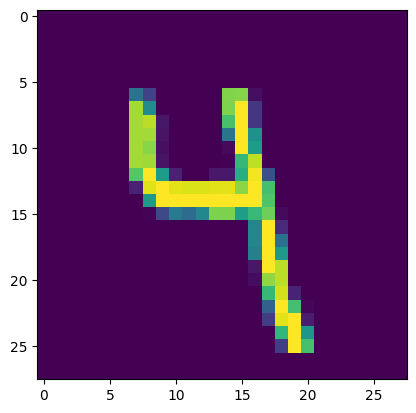

In [ ]:
test_iter = create_batches(test_images, test_labels, batch_size, key)
imgs, labels = next(test_iter)
img = imgs[2].reshape(mnist_img_size)
label_onehot = labels[2]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('label', label_onehot)

plt.imshow(img); plt.show()

# Visualizations

(512, 784)
(28, 28)


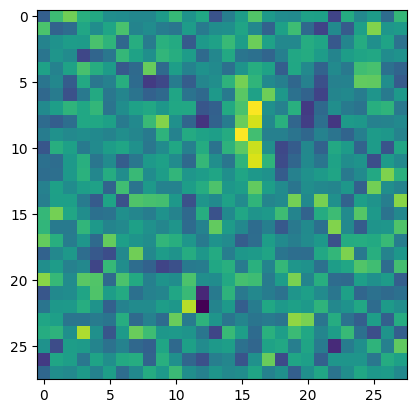

In [ ]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()

(128, 256)


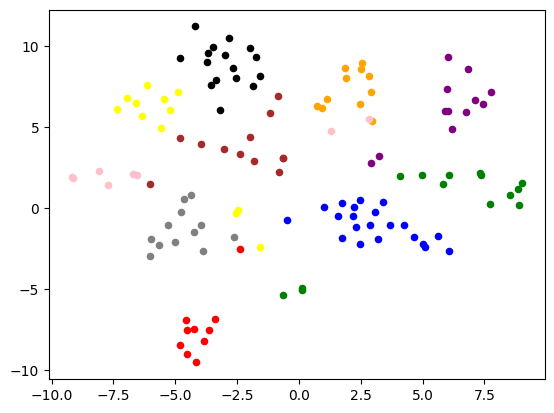

In [ ]:
# todo: visualize embeddings using t-SNE

from sklearn.manifold import TSNE

def fetch_activations(params, x):
    """
    Compute the last hidden-layer activation.
    """
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation

batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))
test_iter = create_batches(test_images, test_labels, batch_size, key)
imgs, labels = next(test_iter)

batch_activations = batched_fetch_activations(MLP_params, imgs)
print(batch_activations.shape)  # (128, 256)

t_sne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(batch_activations)
cora_label_to_color_map = {
    0: "red",
    1: "blue",
    2: "green",
    3: "orange",
    4: "yellow",
    5: "pink",
    6: "gray",
    7: "purple",
    8: "brown",
    9: "black"
}

for class_id in range(10):
    plt.scatter(t_sne_embeddings[labels == class_id, 0], t_sne_embeddings[labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id])
plt.show()